# **Simulación trayectoria POO**

---


Natalia Edith Mejía Bautista

16 marzo, 2024

En este notebook se define el objeto cohete con todas sus propiedades internas actuales.

Tambien se define el objeto viento como vector, el objeto atmosfera y el objeto vuelo.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.interpolate import interp1d
import math
from math import pi

In [ ]:
#esto hay que checar para que funcione
#import pandas as pd
#from google.colab import drive
#drive.mount('/content/drive')

# Replace 'CSV' with the actual folder name
#csv_folder_path = '/content/drive/MyDrive/Tesis/CSVadjuntos'

# Import the necessary CSV files
#data1 = pd.read_csv(csv_folder_path + '/data1.csv')
#data2 = pd.read_csv(csv_folder_path + '/data2.csv')


Objeto viento

In [ ]:
# modelo de viento logaritmico para obtener la magnitud de la velocidad del viento de acuerdo a la altura

def viento_logaritmico(z, z0, u):
    """
    Modelo de viento logaritmico.

    Args:
        z: Altura sobre el suelo (m).
        z0: Altura de rugosidad (m).
        u: Velocidad del viento a 10 m de altura (m/s).

    Returns:
        Velocidad del viento a la altura z (m/s).
    """

    return u * (math.log(z / z0) / math.log(10 / z0))


In [ ]:
import random
class Viento2D:

    def __init__(self, vel_mean=10, vel_var=2):
        self.vel_mean = vel_mean
        self.vel_var = vel_var


        self.magnitud = random.uniform(self.vel_mean - self.vel_var, self.vel_mean + self.vel_var)
        self.direccion = random.uniform(0, 180)
        self.vector = self.magnitud * np.array([np.cos(np.deg2rad(self.direccion)), 0, np.sin(np.deg2rad(self.direccion))])

    def __repr__(self):
        return f"Viento(magnitud={self.magnitud}, direccion={self.direccion})"

viento_actual = Viento2D(vel_mean=10, vel_var=0.05)
print(viento_actual)
print(viento_actual.vector)


Viento(magnitud=9.95592547068724, direccion=39.71489664232975)
[7.65843092 0.         6.36151616]


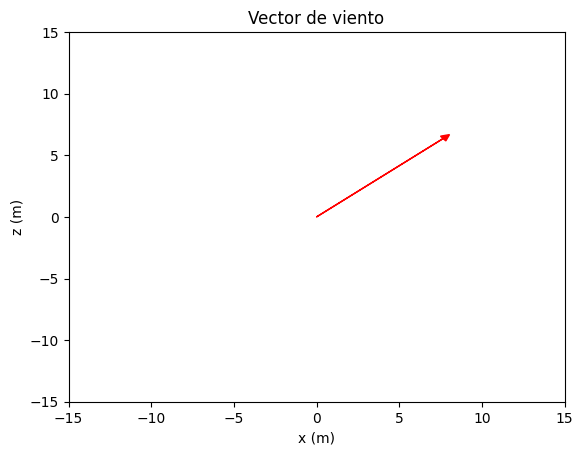

In [ ]:


# Get the x and z components of the wind vector
vx = viento_actual.vector[0]
vz = viento_actual.vector[2]

# Create a plot
fig, ax = plt.subplots()

# Plot the wind vector as an arrow
ax.arrow(0, 0, vx, vz, head_width=0.5, head_length=0.5, color='r', zorder=10)

# Set the limits of the plot
ax.set_xlim([-15, 15])
ax.set_ylim([-15, 15])

# Add labels and title
ax.set_xlabel('x (m)')
ax.set_ylabel('z (m)')
ax.set_title('Vector de viento')

# Show the plot
plt.show()


Objeto torre de lanzamiento

In [ ]:
class Torrelanzamiento:
  def __init__(self, longitud, angulo):
    self.longitud = longitud #[m]
    self.angulo = angulo #[grados]

# riel = Torrelanzamiento(5, 88)
# riel = Torrelanzamiento(5, 45)
riel = Torrelanzamiento(10, 80)
print("Riel de lanzamiento:",riel.longitud,"m", riel.angulo, "º")

Riel de lanzamiento: 10 m 80 º


Función que normaliza y convierte ángulos a grados

In [ ]:
def normalize_angle(angle_deg):
    while angle_deg > 180:
        angle_deg -= 360
    while angle_deg < -180:
        angle_deg += 360
    return angle_deg

def nice_angle(angle_rad):
  return np.array([normalize_angle(x) for x in np.rad2deg(angle_rad)])

In [ ]:
# Constants universales
GravUn = 6.67430E-11  # m^3/kg/s^2 Constante de gravitación universal
Rg = 8.31447   #[J/(mol·K)] Constante universal de los gases
R_Tierra = 6371000 #[m] Radio de la Tierra
M_tierra = 5.972168e24  #[kg] Masa de la Tierra

def calc_gravedad(altura_z):
  return GravUn * M_tierra / (altura_z + R_Tierra)**2

#Calcular la gravedad en la superficie
g0 = calc_gravedad(0)
print(g0)

9.82024967463989


# Objeto Atmósfera
Este objeto contiene las propiedades actuales de la atmosfera de acuerdo a la altura indicada.


In [ ]:
class atmosfera:

    def __init__(self):

      # Constantes
      self.M = 0.0289644 #[kg/mol] Masa molar del aire
      self.cp = 1.4 #Relación de calor especifico
      self.Rg = 287.05287; #[J/K kg] constante gaseosa del aire

      # Capas de la atmósfera
      self.capas = {
        0: (0, 101325, 288.15, 340.29,1.225,-0.0065),#Troposfera
        1: (11000, 22632, 216.65, 295.31,0.3639,0.0), #Tropopausa
        2: (20000, 5474.9, 216.65, 295.31,0.088,0.001), #Estratosfera
        3: (32000, 868.02, 228.65, 296.82,0.0132,0.0028),
        4: (47000, 110.91, 270.65, 294.15,0.002, 0.0),#Estratopausa
        5: (51000, 66.939, 270.65, 294.15,0.002, -0.0028),#Mesosfera
        6: (71000, 3.9564, 214.65, 294.15,0.002, -0.002),
        7: (84852, 0.3734, 186.87, 294.15,0.0, 0.0),#Mesopausa
      }

      # Alturas límite de las capas
      self.h_limite = [0, 11000, 20000, 32000, 47000, 51000, 71000, 84852]

    def altitud_geopot(self, altura_z):
      return (R_Tierra * altura_z)/(R_Tierra+altura_z)

    def determinar_capa(self, altura_z):

      h = self.altitud_geopot(altura_z)

      # Retornar None si estamos más arriba de la última capa o negativa
      if h > self.h_limite[-1]:
        print("Fuera de la atmósfera")
        return None

      # Determina la capa en la que se encuentra la altura h
      for i in range(len(self.capas)-1):
        if h <= self.h_limite[i + 1]:
          capa = self.capas[i]
          return capa

    def calc_propiedades(self, altura_z):

      h = self.altitud_geopot(altura_z)

      capa = self.determinar_capa(altura_z)
      if capa is None:
        return None

      # Calcula los valores
      #capa[0]: Altura geopotencial h
      #capa[1]: Presión base de la capa
      #capa[2]: Temperatura base de la capa
      #capa[3]: Velocidad del sonido en la base de la capa
      #capa[4]: Densidad base de la capa
      #capa[5]: Gradiente adiabatico
      h0 = capa[0]
      P0 = capa[1]
      T0 = capa[2]
      C0 = capa[3]
      rho0 = capa[4]
      L = capa[5]

      if L == 0:
        T = T0
        rho = rho0*np.exp((-g0/(self.Rg*T))*(h-h0))
        presion = P0 * np.exp((-g0/(self.Rg*T))*(h-h0))
      else:
        T = T0 + L*(h-h0)
        rho = rho0 * (T/T0)**(-g0/(L*self.Rg))
        presion = P0 * (T/T0)**(-g0/(L*self.Rg)-1)

      cs = np.sqrt(self.cp*self.Rg*T)

      return (T, rho, presion, cs)



Inicializar atmósfera

In [ ]:
atm_actual = atmosfera()
T, rho, presion, cs = atm_actual.calc_propiedades(10000)
print(T, T-273.15, rho, presion, cs)

223.25186491145587 -49.89813508854411 0.31978138345563417 34139.505741199515 299.5315074878768


# Clase integrador


1. Método de Euler

In [ ]:
class Euler:
    def __init__(self, fun_derivs):
        self.fun_derivadas = fun_derivs

    def step(self, t, state, dt):
        #Aplicar método de Euler para obtener nuevo estado
        state_new = state + (dt * self.fun_derivadas(t, state))
        return state_new

2. Runge-Kutta 4

In [ ]:
class RungeKutta4:
    def __init__(self, fun_derivs):
        self.fun_derivadas = fun_derivs

    def step(self, t, state, dt):
        k1 = self.fun_derivadas(t, state)
        k2 = self.fun_derivadas(t + dt/2, state + k1 * dt/2)
        k3 = self.fun_derivadas(t + dt/2, state + k2 * dt/2)
        k4 = self.fun_derivadas(t + dt, state + k3 * dt)
        new_state = state + dt * (k1 + 2*k2 + 2*k3 + k4) / 6
        return new_state

In [ ]:
# 3. Método de Runge-Kutt-Fehlberg 45
class RKF45:
    def __init__(self, fun_derivs):
        self.fun_derivadas = fun_derivs

    def step(self, t, state, dt, tol=1e-4, S=0.9):

        retry = True
        while retry:
          k1 = self.fun_derivadas(t, state)
          k2 = self.fun_derivadas(t + dt/4, state + (k1 * dt/4))
          k3 = self.fun_derivadas(t + (dt*3/8), state + (k1*3/32) + (k2*9/32) )
          k4 = self.fun_derivadas(t + (dt*12/13), state + (k1*1932/2197) - (k2*7200/2197) + (k3*7296/2197))
          k5 = self.fun_derivadas(t + dt, state + (k1*439/216) - (k2*8) + (k3*3680/513) - (k4*845/4104))
          k6 = self.fun_derivadas(t + dt/2, state - (k1*8/27) + (k2 *2) -  (k3*3544/2565) + (k4 *1859/4104) - (k5 *11/40))

          ykp = state + dt * (25/216*k1 + 1408/2565*k3 + 2197/4101*k4 - k5/5)
          zkp = state + dt * (16/135*k1 + 6656/12825*k3 + 28561/56430*k4 - 9/50*k5 + 2/55*k6)

          errs = np.abs(zkp - ykp)
          errmax = max(errs)

          if errmax < 1:
            # Errores aceptables, ya no iterar más, aumentar dt
            dt_nuevo = min(S*dt*errmax**0.25, 5*dt)
            retry = False
          else:
            # Errores demasiado grandes, reducir dt y repetir paso
            dt_nuevo = max(S*dt*errmax**0.4, dt/10)
            retry = True

        return zkp, dt_nuevo

# 4. Método de Leapfrog
#FALTA CHECAR ESTE INTEGRADOR
class Leapfrog:
    def __init__(self, fun_derivs):
        self.fun_derivadas = fun_derivs

    def step(self, t, state, dt):
        state_half = state + (dt/2) * self.fun_derivadas(t, state)
        state_new = state_half + dt * self.fun_derivadas(t + dt/2, state_half)
        return state_new


In [ ]:
t_max = 25
estado = 1
dt = 0.5

def derivada(t, y):
  return y * t**2 - 1.2 * y

def resolverEDO(estado, t_max, dt):
  t=0
  it=0
  Integracion = RungeKutta4(derivada)

  estados=[estado]
  tiempos=[0]

  while t <= t_max:
    nuevo_estado = Integracion.step(t, estado, dt)

    estados.append(nuevo_estado)
    tiempos.append(t)

    it += 1
    t += dt
  return tiempos, estados

TypeError: unsupported operand type(s) for *: 'UndefinedFunction' and 'Symbol'

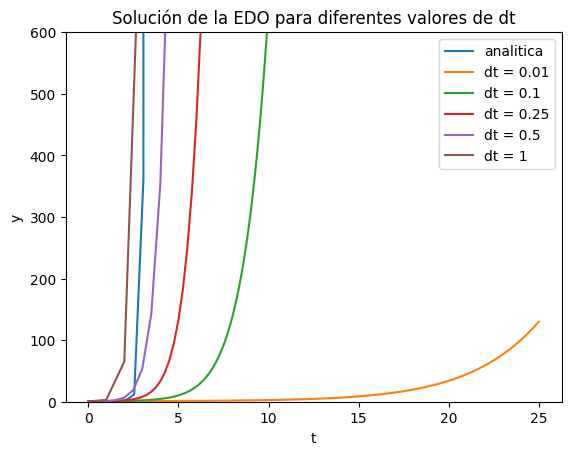

In [ ]:

# Define the time steps
dt_values = [0.01, 0.1, 0.25, 0.5, 1]

# Initialize lists to store the results
tiempos = []
estados = []
solucion=[]

# Loop over the different time steps
for dt in dt_values:
  # Solve the ODE for the current time step
  t, y = resolverEDO(estado, t_max, dt)
  #y_a = sol(t)

  # Store the results
  tiempos.append(t)
  estados.append(y)
  #solucion.append(y_a)
#plt.plot(x_val,y_val, label="analitica")
#plt.plot(tiempos, solucion, label='Solucion')
# Plot the results
for i in range(len(dt_values)):
  plt.plot(tiempos[i], estados[i], label=f'dt = {dt_values[i]}')

plt.xlabel('t')
plt.ylabel('y')
plt.ylim(0,600)
plt.title('Solución de la EDO para diferentes valores de dt')
plt.legend()
plt.show()


# Clase Componentes
Para definir todo los que sea un componente del cohete. Consta de una masa y sus posicion en el eje longitudinal del cohete.

In [ ]:
class Componente:
    def __init__(self, nombre, masa, posicion):
        self.nombre = nombre
        self.masa = masa
        self.posicion = posicion # Se refiere a la posicion de la parte frontal del component en el sistema de coordenadas del cohete
        self.CG = None
        self.CP = None
        self.Ix = 0     # Momento de inercia en torno a un eje "horizontal" (perpendicular al eje longitudinal) que pasa por el CG del componente


Las distancias se van a tomar sobre una recta que empieza con 0 en la punta de la nariz y L, la longitud total del vehiculo, hacia la derecha.

## 1. SubClase Cono

In [ ]:
# Cilindro con la punta hacia arriba
class Cono(Componente):

    # Las coordenadas locales se miden desde la punta hacia abajo
    def __init__(self, nombre, masa, posicion, longitud, diametro, geometria):
        super().__init__(nombre, masa, posicion)  # Solo se pasan 3 argumentos a la clase base
        self.long = longitud
        self.bottom = self.posicion + self.long
        self.diam = diametro
        self.geom = geometria
        self.rad = self.diam/2
        self.CG = None
        self.CP = None
        self.CN = None
        self.Ix = None
        self.calc_CG()
        self.calc_CP()
        self.calc_Ix()

    # Posicioón del centro de gravedad en coordenadas locales
    def calc_CG(self):
      self.CG = np.array((0.0, 0.0, (3/4) * self.long))

    # Calcula centro de presión en coordenadas locales
    def calc_CP(self):
      # Coeficientes de presión aerodinámica
      if self.geom == "conica":
        k = 2/3
      elif self.geom == "ogiva":
        k = 0.466
      elif self.geom == "parabolica":
        k = 0.5
      elif self.geom == "eliptica":
        k = 0.333
      else:
        raise Exception("Error: geometría '{}' no está en la lista".format(self.geom))
      self.CP = np.array((0.0, 0.0, k * self.long))
      self.CN = 2.0

    # Calcula momento de inercia con respecto a su centro de gravedad
    def calc_Ix(self):
      self.Ix = self.masa * ((3/20)*self.rad**2+(3/80)*self.long**2)



## 2. SubClase Cilindro

Usado para componentes de la estructura del cohete como bahias o tanques vacios.

In [ ]:
class Cilindro(Componente):

    def __init__(self, nombre, masa, posicion, longitud, diametroexterior, diametrointerior):
        super().__init__(nombre, masa, posicion)  # Solo se pasan 3 argumentos a la clase base
        self.long = longitud #Longitud del tubo
        self.bottom = self.posicion + self.long
        self.diam_ext = diametroexterior #Diametro exterior del tubo
        self.diam_int = diametrointerior #Diametro interior del tubo
        self.rad_ext = self.diam_ext/2
        self.rad_int = self.diam_int/2
        self.CG = None
        self.CP = None
        self.CN = None
        self.Ix = None
        self.calc_CG()
        self.calc_CP()
        self.calc_Ix()

    def calc_CG(self):
      self.CG = np.array((0.0, 0.0, (1/2) * self.long))

    def calc_CP(self):
      self.CP = np.array((0.0, 0.0, 0.0))
      self.CN = 0

    def calc_Ix(self):
      self.Ix = (1/12) * self.masa * ((3*(self.rad_int**2 + self.rad_ext**2)) + self.long**2)


## 5. SubClase Aletas

In [ ]:
class Aletas(Componente): #Incluye el arreglo de aletas completo

    def __init__(self, nombre, masa, posicion, diametro, numf, semispan, C_r, C_t, X_R,mid_sweep):
        super().__init__(nombre, masa, posicion)  # Solo se pasan 3 argumentos a la clase base

        self.diam_fus = diametro
        self.rad_fus = self.diam_fus/2

        self.numf = numf             #[1] Numero de Aletas
        self.semispan = semispan     #[m] Fin semi span
        self.span = self.semispan  # son lo mismo? checar la def
        self.C_r = C_r           #[m] Root-chord length
        self.C_t = C_t           #[m] Tip-chord length
        self.bottom = self.posicion + self.C_r

        self.X_R = X_R            #[m] Distancia del inicio de las aletas al Tip-chord
        self.mid_sweep = mid_sweep
        self.mid_chord_span = self.span / np.cos(self.mid_sweep)
        self.tip_le = self.C_r / 2 + self.span * np.tan(self.mid_sweep) - self.C_t / 2  # tip leading edge
        self.leading_sweep = np.arctan(self.tip_le / self.span)
        self.gamma = self.leading_sweep

        self.CG = None
        self.CP = None
        self.CN = None
        self.Ix = None
        self.calc_CG()
        self.calc_CP()
        self.calc_Ix()

    def calc_CG(self):

      self.CG = np.array((0.0, 0.0, 0.0))
      self.CG[2]=(self.C_r**2 + self.C_r * self.C_t + self.C_t**2 + (3 * (self.C_r + self.C_t) * self.rad_fus + (self.C_r + 2 * self.C_t) * self.span) * np.tan(self.gamma)) / (3 * (self.C_r + self.C_t))

    def calc_CP(self):
      theta = np.arctan(1/self.semispan*(self.X_R+ 0.5*(self.C_t-self.C_r)))
      l = self.semispan/ np.cos(theta)
      raiz = np.sqrt(1+(2*l/(self.C_r + self.C_t))**2)

      self.CP = np.array((0.0, 0.0, 0.0))
      #coordenada z del
      self.CP[2] = (self.X_R/3)*((self.C_r+ 2*self.C_t)/(self.C_r + self.C_t))+ 1/6 * ((self.C_r + self.C_t) - (self.C_r*self.C_t/(self.C_r + self.C_t)))
      self.CN = (1+ (self.rad_fus/(self.semispan+self.rad_fus)))*((4*self.numf*((self.semispan/(self.rad_fus*2))**2))/(1+raiz))

    def calc_Ix(self):
      Ix_m = (1 / (18 * (self.C_r + self.C_t)**2)) * (self.C_r**4 + 2 * self.C_r**3 * self.C_t + 2 * self.C_r * self.C_t**3 + self.C_t **4 - (self.C_r**2 + 4 * self.C_r * self.C_t + self.C_t**2) * self.span * np.tan(self.gamma) * (self.C_r - self.C_t - self.span * np.tan(self.gamma)))
      self.Ix = self.masa * Ix_m

## 6. SubClase Boattail -- REVISAR

In [ ]:
class Boattail(Componente):

    def __init__(self, nombre, masa, posicion, longitud, diamF_boat, diamR_boat, espesor):

        super().__init__(nombre, masa, posicion)  # Solo se pasan 3 argumentos a la clase base
        self.long = longitud #Longitud del tubo
        self.bottom = self.posicion + self.long
        self.dF = diamF_boat  # [m] Boat-tail diametro frontal
        self.dR = diamR_boat   # [m] Boat-tail diametro trasero
        self.e = espesor #espesor
        self.radF = self.dF/2
        self.radR = self.dR/2

        self.A_ref = np.pi * self.dF**2 / 4

        self.CG = None
        self.CP = None
        self.CN = None
        self.Ix = None
        self.calc_CG()
        self.calc_CP()
        self.calc_Ix()

    def calc_CG(self):
      self.CG = np.array((0.0, 0.0, 0.0))
      self.CG[2]= (self.long / 3) * (self.radF + 2 * self.radR) / (self.radF + self.radR)

    def calc_CP(self):
      self.CP = np.array((0.0, 0.0, 0.0))
      dimrel= self.dF/self.dR
      #self.CP[2] = (self.long / 3) * ((self.dF + 2 * self.dR) / (self.dR + self.dF))
      self.CP[2]=(self.long/3)*(1+((1-dimrel)/(1-dimrel**2)))
      self.CN = (2/self.dF**2)*(self.dR**2-self.dF**2)

    def calc_Ix(self):
      self.Ix = self.masa * (0.5 * (self.radF**2 + self.radR**2))

# Objeto cohete
Tiene las caracteristicas generales del cohete y esta compuesto por sus componentes.

In [ ]:
class Cohete:

    def __init__(self, nombre, tipo, componentes,componentes_externos):

        self.nombre = nombre
        self.tipo = tipo    # El tipo de cohete (string)
        self.componentes = componentes   # Una lista de objetos Componente (o derivados)
        self.num_comp = len(self.componentes)
        self.componentes_externos = componentes_externos

        self.t = None
        self.state = None # [x,y,z,vx,vy,vz,pitch,velang]
        self.posicion = None
        self.velocidad = None
        self.pitch = None
        self.velang = None

        self.masa = None
        self.CG = None
        self.CP = None
        self.CN = None
        self.Ix = None
        self.A = None


        self.calc_A()
        self.calc_masa()
        self.calc_mom_inercia_total()
        self.calc_CP()
        self.calc_CN()

        self.longtotal = boattail.bottom[2]

        self.cargar_tablas_motor()
        self.cargar_tabla_Cd()

        self.parachute_added = False
        self.parachute_active1 = None
        self.parachute1 = None

    def agregar_paracaidas(self, parachute_n):
      self.parachute_added = True
      self.parachute_active1 = False
      self.parachute1 = parachute_n

    #def activar_paracaidas(self, parachute_n):
      #self.parachute_active1 = True

    def cargar_estado(self,estado):
      self.state = estado
      self.posicion = estado[0:3]
      self.velocidad = estado[3:5]
      self.pitch = estado[6]
      self.velang = estado[7]

    # Calcular el área transversal efectiva del cohete (según fuselaje)
    def calc_A(self):
      self.A = pi * self.componentes['coples'].rad_ext**2

    # Calcula la masa total del cohete sumando las masas de sus componentes
    def calc_masa(self):
      self.masa = 0.0
      for comp in self.componentes.values():
        self.masa += comp.masa

    # Calcula el centro de gravedad con base en las masas y posiciones de sus componentes
    def calc_CG(self):
      if self.masa is None: self.calc_masa()
      self.CG = np.array((0.0, 0.0, 0.0))
      for comp in self.componentes.values():
        self.CG += (comp.posicion + comp.CG) * comp.masa
      self.CG /= self.masa

    # Calcular el momento de inercial total en torno a un eje "horizontal" (perpendicular al eje longitudinal) respecto al CG de todo el cohete
    # Se aplica el teorema de ejes paralelos para combinar los momentos de inercia de los componentes individuales
    def calc_mom_inercia_total(self):
      self.Ix = 0.0
      if self.CG is None: self.calc_CG()
      for comp in self.componentes.values():
        self.Ix += comp.Ix + comp.masa*np.linalg.norm((comp.posicion + comp.CG) - self.CG)**2

    def calc_CP(self):
      self.CP = np.array((0.0, 0.0, 0.0))
      CN_tot = 0.0
      for comp in self.componentes.values():
        self.CP += (comp.posicion + comp.CP) * comp.CN
        CN_tot += comp.CN
      self.CP /= CN_tot

    def calc_CN(self):
      self.CN = 0
      for comp in self.componentes.values():
        self.CN += comp.CN

    def vuela(self):
      print("Vuela porfavor")

    def cargar_tabla_Cd(self):
      self.CdTable = pd.read_csv('cdmachXitle.csv')

    def cargar_tablas_motor(self):

      #self.motorThrustTable = pd.read_csv('MegaPunisherBien.csv') #Importar la curva de empuje
      self.motorThrustTable = pd.read_csv("pruebaestaica28mayo2024.csv")
      self.t_MECO = self.motorThrustTable['time'].max() #tiempo en que se acaba el empuje

      self.motorMassTable = pd.read_csv('MegaPunisherFatMasadot.csv')
      self.motorMassTable['time'] = self.motorMassTable['Time (s)']
      self.motorMassTable['oxi'] = self.motorMassTable['Oxidizer Mass (kg)']
      self.motorMassTable['grano'] = self.motorMassTable['Fuel Mass (kg)']

      # Calcular el área de la curva empuje vs tiempo utilizando la regla del trapecio
      #Vamos a probar otro tipo de integracion para mejorarlo?
      self.I_total = np.trapz(y=self.motorThrustTable['thrust'], x=self.motorThrustTable['time'])

    def calc_empuje(self, t):
      if t > self.t_MECO:
        return 0
      else:
        # Realizar interpolación
        return np.interp(t, self.motorThrustTable['time'], self.motorThrustTable['thrust'])

    def actualizar_masas_motor(self, t):
      p = len(self.motorMassTable['time'])
      if t > self.t_MECO:
        #Actualizar la masa del componente
        self.componentes['oxidante'].masa = self.motorMassTable['oxi'][p-1]
        self.componentes['grano'].masa = self.motorMassTable['grano'][p-1]
      else:
        self.componentes['oxidante'].masa = np.interp(t, self.motorMassTable['time'], self.motorMassTable['oxi'])
        self.componentes['grano'].masa = np.interp(t, self.motorMassTable['time'], self.motorMassTable['grano'])

    def calc_arrastre_normal(self, pos, vel, alpha):
      altura = pos[2] #self.posicion[2]
      vel_mag = np.linalg.norm(vel)
      #print(altura)
      T, rho, presion, cs = atm_actual.calc_propiedades(altura)
      mach =  vel_mag / cs #mach variable
      Cd = np.interp(mach, self.CdTable['mach'], self.CdTable['cd'])
      # DEBUG: aumentar Cd
      # Cd *= 5

      f_arrastre = 0.5 * rho * Cd * self.A * vel_mag**2
      f_normal = 0.5 * rho * self.CN * self.A  * vel_mag**2 * np.sin(alpha) * np.sin(alpha)

      if self.parachute_active1 == True:
        coef_par = self.parachute1.cd
        area_par = self.parachute1.Area_trans
        f_paracaidas = 0.5 *rho* coef_par * area_par * vel_mag**2
        f_arrastre = f_arrastre  + f_paracaidas
      else:
        pass
        #print(f_paracaidas)

      # if alpha == 0:
      #   f_normal = 0.5 * rho * self.CN * self.A  * vel_mag**2
      # else:
      #   f_normal = 0.5 * rho * np.sin(alpha)/alpha * self.CN * self.A  * vel_mag**2

      #print(f_arrastre, "arrastre")
      #print(f_normal, "normal")
      return f_arrastre, f_normal, Cd, mach

    def actualizar_masa(self, t):
      # Actualizar masa de motor
      self.actualizar_masas_motor(t)
      #Calcular masa del cohete copleto (con el nuevo motor)
      self.calc_masa()
      #Calcular CG
      self.calc_CG()

    def calc_angles(self, pos, vel, theta):
        # Ángulo de vuelo (flight path angle)
        r = np.linalg.norm(pos)
        if r <= riel.longitud:
          gamma = theta
        else:
          gamma = math.atan2(vel[2], vel[0])
        # Angulo de ataque
        alpha = theta - gamma
        return gamma, alpha

    def empuje(self, t, zbhat):
      Tmag = self.calc_empuje(t)
      #Calcular las componentes del empuje
      #La direccion del empuje es en sentido a la velocidad
      Tvec = Tmag * zbhat
      return Tvec

    def calc_aero(self, pos, vel, vhat, alpha):
      if pos[2] <= 85000: #si todavía esta en la atmosfera definida
        #print(self.calc_arrastre_normal(pos,vel,alpha))
        Dmag, Nmag, Cd, mach = self.calc_arrastre_normal(pos, vel, alpha)
        #print(Cd,mach)
        #print(Dmag,"mag arrastre")
        #Fuerza normal
        #Falta la variacion, que sea funcion de theta (pitch)
        Dvec = - Dmag * vhat
        #print(vhat, Dvec)
        nhat = np.array((vhat[2], vhat[1], -vhat[0]))
        # Tal vez invertir el vector para que la componente x tenga el
        # mismo signo que la componente x de -vhat
        # DEBUG: apagar normal
        #Nmag = 0
        Nvec = Nmag * nhat
        return Dvec, Nvec, Cd, mach
      else:
        return np.zeros(3), np.zeros(3)

    def accangular(self, theta, Dvec, Nvec, Gvec):
      # Calcular brazo de momentos
      # r es un vector que apunta del CG al CP, en coords de cuerpo del cohete,
      # donde la nariz es el origen y el eje Z apunta hacia la cola
      palanca_b = self.CP - self.CG
      s = np.sin(theta)
      c = np.cos(theta)
      # Transformar a coordenadas del suelo
      M_rot = np.array([[s,0,-c],[0, 1, 0],[c, 0 , -s]])
      palanca = M_rot @ palanca_b   # palanca en coord del suelo

      #Calcular las torcas
      #print(Dvec,"arrastre")
      tau_D = np.cross(palanca, Dvec)

      tau_N = np.cross(palanca, Nvec)
      tau_tot = tau_D + tau_N
      #torcas.append((tau_D, tau_N))
      #torcas.append((tau_tot))
      #palancas.append(palanca)

      #suma de torcas/ momento de inercia total
      # se toma la componente y (perpendicular al plano de vuelo ZX) y se
      # multiplica por -1 porque el eje y apunta hacia "adentro"
      Torca = -tau_tot[1]
      Torca = Torca*10
      accang = Torca / self.Ix # se debe usar el momento de inercia actualizado
      #angaccels.append(accang)
      return palanca, accang, Torca


    def fun_derivs(self, t, state):

      # state, posicion y velocidad son estados intermedios
      #no necsariamente los del cohete
      pos = state[0:3]
      vel = state[3:6]
      #velocidadvector.append(vel)
      theta = state[6]   # En radianes internamente siempre
      omega = state[7] #omeg a= theta dot
      # r = np.linalg.norm(pos)
      # v = np.linalg.norm(vel)
      z = pos[2] #Coordenada z

      accel = np.array([0,0,0])

      # Angulos
      gamma, alpha = self.calc_angles(pos, vel, theta)

      # Vectores unitarios para la nariz y la velocidad
      zbhat = np.array((np.cos(theta), 0, np.sin(theta)))
      vhat = np.array((np.cos(gamma), 0, np.sin(gamma)))


      #vectores para velocidad considerando el viento
      if pos[2] <= 1000:
        v_viento = np.array([0,0,0])
      else:
        viento_actual =Viento2D( 5, 0.02)
        v_viento = viento_actual.vector
      #v_viento = np.array([0,0,0])
      v_rel =  v_viento - vhat
      v_rel_hat = v_rel / np.linalg.norm(v_rel)
      #v_viento = viento_actual.vector
      #v_viento = np.array([0,0,0])
      v_rel =  v_viento - vhat
      v_rel_hat = v_rel / np.linalg.norm(v_rel)
      #print(v_rel_hat)


      #Calcular las componentes del empuje
      Tvec = self.empuje(t, zbhat)
      #print(Tvec)

      # Arrastre y fuerza normal
      #Para considerar el viento: cambiar vhat por v_rel_hat??
      #print(self.calc_aero(pos, vel, v_rel_hat, alpha))
      Dvec, Nvec, Cd, mach = self.calc_aero(pos, vel, vhat, alpha)
      #print("Vectores de arrastre y normal",Dvec, Nvec)


      # Gravedad
      grav = calc_gravedad(z)
      Gvec = np.array([0,0,-grav])

      # Aceleración resultante de todas las fuerzas
      accel = Gvec + Dvec/self.masa + Nvec/self.masa + Tvec/self.masa

      #Velocidad angular
      velang = omega

      # aceleracion angular
      palanca, accang, torca = self.accangular(theta, Dvec, Nvec, Gvec)

      # PRUEBA: apagar parte angular
      # omega = 0
      # accang= 0

      derivs = np.concatenate((vel, accel, [omega], [accang]))
      #print(derivs)

      return derivs

# Caso particular: Xitle
El siguiente script define las propiedades del Xitle desarrollado por Propulsión UNAM.

**Todas las dimensiones deben estar en metros**

In [ ]:
diam_ext = 0.152
espesor = 0.003
#Creación de los componentes individuales

#Componentes externos
nariz = Cono("Nariz", 0.8 , np.array([0.0, 0.0, 0.0]), 0.81, diam_ext, "ogiva")
coples = Cilindro("Coples",1.5, np.array([0.0,0.0, nariz.bottom[2]]),0.176, diam_ext, diam_ext-espesor)
tubo_recup = Cilindro("Tubo recuperación", 2.3, np.array([0.0, 0.0, coples.bottom[2]]), 0.92, diam_ext, diam_ext-espesor)
transfer = Cilindro("Transferidor", 1, np.array([0.0, 0.0, tubo_recup.bottom[2]]), 0.25, diam_ext, diam_ext-espesor)
#tanquelleno = Cilindro("Tanquelleno", 22.0, np.array([0.0, 0.0, fuselaje.bottom[2]]), 1.33, diam_ext, 0)
tanquevacio = Cilindro("Tanquevacio", 8.7, np.array([0.0, 0.0, transfer.bottom[2]]), 1.25, diam_ext, diam_ext-espesor)
#NOX
valvulas = Cilindro("Valvulas", 2.4 , np.array([0.0, 0.0, tanquevacio.bottom[2]]), 0.167, diam_ext, diam_ext-espesor)
#Grano
CC = Cilindro("Camara de Combustión", 4.3, np.array([0.0, 0.0,valvulas.bottom[2]]),0.573,diam_ext, 0.102)

boattail = Boattail("Boattail", 0.251, np.array([0.0, 0.0, CC.bottom[2]]), 0.12, diam_ext, 0.132, espesor)

#Componentes internos
avionica = Cilindro("Aviónica", 1.8, np.array([0.0, 0.0, 0.20]), 0.21, 0.14, 0)
CU = Cilindro("CU", 4.3, np.array([0.0, 0.0, 0.50]), 0.3, 0.14, 0)
drogue = Cilindro("Drogue", 0.6, np.array([0.0, 0.0, 1.0]), 0.17, 0.14, 0)
main = Cilindro("Main", 1.7, np.array([0.0, 0.0, 1.4]), 0.30, 0.14, 0)
aletas= Aletas("Aletas", 1.1, np.array([0.0, 0.0, CC.bottom[2]]), diam_ext, 4, 0.11, 0.3, 0.1, 0.2, 25)

#Combustibles del cohete
oxidante = Cilindro("Oxidante", 12.0, np.array([0.0, 0.0, transfer.bottom[2]]), 1.33, 0.1461, 0)
grano = Cilindro("Grano", 4.0 , np.array([0.0, 0.0, valvulas.bottom[2]]), 0.505 , 0.158, 0.334)

#Lista de componentes y creación del vehículo completo
#Debe ser un diccionario con un nombre corto para cada componente
componentes = {'Nariz': nariz ,'coples': coples,'Tubo recuperación': tubo_recup, 'Transferidor de carga': transfer, 'Aviónica': avionica, 'Carga Útil': CU, 'drogue': drogue,
               'main': main, 'tanquevacio': tanquevacio,
               'oxidante': oxidante, 'valvulas': valvulas, 'grano': grano, 'Cámara Combustión': CC, 'Aletas': aletas, 'Boattail': boattail}

componentes_externos = {'Nariz': nariz ,'coples': coples,'Tubo recuperación': tubo_recup, 'Transferidor de carga': transfer, 'tanquevacio': tanquevacio,
               'oxidante': oxidante, 'valvulas': valvulas, 'grano': grano, 'Cámara Combustión': CC, 'Boattail': boattail}
Xitle = Cohete("Xitle", "hibrido", componentes, componentes_externos)

#print(Xitle)

#NOTA: en los bottom de todos los componentes tambien se esta sumando la longitud a los ejes x y
#print(boattail.bottom)
print("El centro de gravedad es:",Xitle.CG[2], "metros")
print("El centro de presión es:", Xitle.CP[2], "metros")
#print(Xitle.CN)
print("La masa inicial total es:",Xitle.masa, "kg")
print("El impulso total es:", Xitle.I_total, "N s")


El centro de gravedad es: 2.523544046435205 metros
El centro de presión es: 3.134221098491882 metros
La masa inicial total es: 46.75099999999999 kg
El impulso total es: 21138.8713128 N s


In [ ]:
CG_list=[]
CP_list=[]
Ix_list=[]
long_list=[]
masas_list=[]

for comp in Xitle.componentes.values():
  long_list.append(0.0)
  long_list.append(comp.bottom[2])

print("\nMasas")
for comp in Xitle.componentes.values():
  masas_list.append(comp.masa)
  print(comp.nombre, comp.masa)

masas_list.append(Xitle.masa)
print(Xitle.nombre, Xitle.masa)

print("\nCentros de gravedad")
for comp in Xitle.componentes.values():
  CG_list.append(comp.posicion[2]+comp.CG[2])
  print(comp.nombre, comp.posicion[2] + comp.CG[2])

CG_list.append(Xitle.CG[2])
print(Xitle.nombre, Xitle.CG[2])

print("\nCentros de presión")
for comp in Xitle.componentes.values():
  CP_list.append(comp.posicion[2]+comp.CP[2])
  print(comp.nombre, comp.posicion[2] + comp.CP[2], comp.CN)

CP_list.append(Xitle.CP[2])
print(Xitle.nombre, Xitle.CP[2])

print("\nMomentos de inercia")
for comp in Xitle.componentes.values():
  print(comp.nombre, comp.Ix)
print(Xitle.nombre, Xitle.Ix, "[kg m^2]")

print("\n Datos generales")
print("La longitud total de Xitle es", Xitle.longtotal, "[m]")
print("La masa total de Xitle es", Xitle.masa, "[kg]")
print("El impulso total del motor es", Xitle.I_total)


Masas
Nariz 0.8
Coples 1.5
Tubo recuperación 2.3
Transferidor 1
Aviónica 1.8
CU 4.3
Drogue 0.6
Main 1.7
Tanquevacio 8.7
Oxidante 12.0
Valvulas 2.4
Grano 4.0
Camara de Combustión 4.3
Aletas 1.1
Boattail 0.251
Xitle 46.75099999999999

Centros de gravedad
Nariz 0.6075
Coples 0.898
Tubo recuperación 1.446
Transferidor 2.031
Aviónica 0.305
CU 0.65
Drogue 1.085
Main 1.5499999999999998
Tanquevacio 2.781
Oxidante 2.821
Valvulas 3.4895
Grano 3.8255
Camara de Combustión 3.8594999999999997
Aletas 4.348822941835452
Boattail 4.204591549295775
Xitle 2.523544046435205

Centros de presión
Nariz 0.37746 2.0
Coples 0.81 0
Tubo recuperación 0.986 0
Transferidor 1.9060000000000001 0
Aviónica 0.2 0
CU 0.5 0
Drogue 1.0 0
Main 1.4 0
Tanquevacio 2.156 0
Oxidante 2.156 0
Valvulas 3.406 0
Grano 3.573 0
Camara de Combustión 3.573 0
Aletas 4.2835 5.255306061185453
Boattail 4.204591549295775 -0.4916897506925206
Xitle 3.134221098491882

Momentos de inercia
Nariz 0.020376120000000005
Coples 0.00811934375
Tubo recup

# Objeto paracaidas??
Para la etapa de recuperación en el vuelo

In [ ]:

class Parachute:
    def __init__(self, cd, area_trans):
        self.cd = cd
        self.Area_trans = area_trans


# Objeto Vuelo


Prueba de que el integrador avanza un paso al vector de estados [$x,y,z,v_x,v_y,v_z,\theta,\omega$]

# SIMULACIÓN

In [ ]:
class Vuelo:

    def __init__(self, vehiculo_actual, atm_actual, viento_actual):

        self.vehiculo = vehiculo_actual #Vehiculo actual
        self.atm = atm_actual #atmosfera actual
        self.viento = viento_actual
        self.parachute1 = vehiculo_actual.parachute1 #paracaidas

        #hacer una lista de etapas de vuelo
        #self. etapas = [enriel , motorON, apogeo, droguerec, mainrec]
        #para cada etapa guardar el tiempo en que ocurrio y sus valores máximos

    def simular_vuelo(self, estado, t_max, dt):
      CPs=[]
      CGs=[]

      t = 0
      it = 0

      self.vehiculo.cargar_estado(estado)

      #CAMBIO DE METODO DE INTEGRACIÓN
      #Integracion = Euler(Xitle.fun_derivs)
      Integracion = RungeKutta4(self.vehiculo.fun_derivs)
      #Integracion = RKF45(self.vehiculo.fun_derivs)
      #Integracion = Leapfrog(self.vehiculo.fun_derivs)


      sim=[estado] #lista de estados de vuelo
      tiempos=[0] #lista de tiempos

      self.vehiculo.actualizar_masa(t)
      masavuelo=[self.vehiculo.masa]

      ultima_altitud = None
      self.tiempo_salida_riel = None
      self.tiempo_apogeo = None
      self.tiempo_impacto = None

      while t <= t_max:

        nuevo_estado = Integracion.step(t, estado, dt)
        self.vehiculo.cargar_estado(nuevo_estado)

        it += 1
        t+= dt

        self.vehiculo.parachute_active1 = False
        #print(self.vehiculo.parachute_active1)

        tiempos.append(t)
        estado = nuevo_estado


        CPs.append(self.vehiculo.CP)
        CGs.append(self.vehiculo.CG)

        self.vehiculo.actualizar_masa(t)
        #Agregar nueva masa a la lista
        masavuelo.append(self.vehiculo.masa)

        #FASE 1. VUELO EN RIEL

        if self.tiempo_salida_riel is None:
          r = np.linalg.norm(estado[0:3])
          if r > riel.longitud:
            self.tiempo_salida_riel = t
       #FASE 2. MECO

        # APOGEO: Determinar tiempo de apogeo
        altitud = estado[2]
        if self.tiempo_apogeo is None and altitud > 5 and altitud < ultima_altitud:
          self.tiempo_apogeo = t

        ultima_altitud = altitud

       #FASE3.RECUPERACIÓN
        #activar el paracaidas en el apogeo
        if self.tiempo_apogeo is not None and self.vehiculo.parachute_added == True:
          #print(self.vehiculo.parachute_active1,"antes")
          self.vehiculo.parachute_active1 = True
          #print(self.vehiculo.parachute_active1,"despues")
          #print("Se ha abierto el paracaídas")
          #self.vehiculo.activar_paracaidas(self.vehiculo.parachute1)
        else:
          pass


        #CAIDA: Terminar simulación cuando cae al piso
        if estado[2] < 0 and t > 1:
          self.tiempo_impacto = t
          break

        #Agrega el nuevo estado a la lista
        sim.append(estado)


        #self.vehiculo.parachute_added = False

      return tiempos, sim, CPs, CGs, masavuelo

    def calc_cantidades_secundarias(self, tiempos, estados):

      Tvecs = []
      Dvecs = []
      Nvecs = []

      accels=[]
      palancas=[]
      accangs=[]
      torcas = []

      Gammas = []
      Alphas = []

      Cds=[]
      Machs=[]

      vientomag = []
      vientodir = []

      #print(tiempos)

      for i in range(len(tiempos)-1):

        # Desempaquetar vector de estado
        state = estados[i]
        pos = state[0:3]
        vel = state[3:6]
        #velocidadvector.append(vel)
        theta = state[6]   # En radianes internamente siempre
        omega = state[7] #omeg a= theta dot
        r = np.linalg.norm(pos)
        v = np.linalg.norm(vel)
        z = pos[2] #Coordenada z

        #Guardar Angulos
        gamma, alpha = self.vehiculo.calc_angles(pos, vel, theta)
        Gammas.append(gamma)
        Alphas.append(alpha)

        # Vectores unitarios de dirección
        zbhat = np.array((np.cos(theta), 0, np.sin(theta)))
        vhat = np.array((np.cos(gamma), 0, np.sin(gamma)))

        #vectores para velocidad considerando el viento
        if pos[2] <= 1000: #10 m
          v_viento = np.array([0,0,0])
          vientomag.append(0)
          vientodir.append(0)
        else:
          viento_actual = Viento2D(vel_mean=10, vel_var=0.2)
          v_viento = viento_actual.vector
          vientomag.append(viento_actual.magnitud)
          vientodir.append(viento_actual.direccion)
        #v_viento = np.array([0,0,0])



        v_rel =  v_viento - vhat
        v_rel_hat = v_rel / np.linalg.norm(v_rel)
        #v_viento = viento_actual.vector
        #v_viento = np.array([0,0,0])
        v_rel =  v_viento - vhat
        v_rel_hat = v_rel / np.linalg.norm(v_rel)
        #print(v_rel_hat)

        #print(vhat, v_viento, v_rel, v_rel_hat)


        #Guardar Fuerzas:Empuje,Arrastre y Normal
        Tvec = self.vehiculo.empuje(tiempos[i], zbhat)

        Dvec, Nvec, Cd, mach = self.vehiculo.calc_aero(pos, vel, vhat, alpha)
        Tvecs.append(Tvec)
        Dvecs.append(Dvec)
        Nvecs.append(Nvec)
        Cds.append(Cd)
        Machs.append(mach)

        # Gravedad
        grav = calc_gravedad(z)
        Gvec = np.array([0,0,-grav])

        # Aceleración resultante
        masa = self.vehiculo.masa
        accel = Gvec + Dvec/masa + Nvec/masa + Tvec/masa
        accels.append(accel)

        # aceleracion angular
        palanca, accang, torca = self.vehiculo.accangular( theta, Dvec, Nvec, Gvec)
        palancas.append(palanca)
        accangs.append(accang)
        torcas.append(torca)

      return Tvecs, Dvecs, Nvecs, accels, palancas, accangs, Gammas, Alphas, torcas, Cds, Machs, vientomag, vientodir

    def muestra_tiempos(self):
      plt.axvline(self.tiempo_salida_riel, color="orange", ls="--")
      plt.axvline(Xitle.t_MECO, color="darkred", ls="--")
      plt.axvline(self.tiempo_apogeo, color="navy", ls="--")
      plt.axvline(self.tiempo_impacto, color="0.2", ls="--")



Simulacion en accion (sin paracaidas)

In [ ]:
#quitar el paracaidas
Xitle.parachute_added = False
#desactivar el paracaidas
Xitle.parachute_active1 = False

# Estado inicial
x0, y0, z0 = 0, 0, 0
vx0, vy0, vz0 = 0, 0, 0
theta0, omega0 = np.deg2rad(riel.angulo), 0
estado=np.array([x0, y0, z0, vx0, vy0, vz0, theta0, omega0])

#Parametros de la simulacion
dt=0.01 #[s]
t_max = 600 #[s]

#t=0
#it = 0

vuelo1 = Vuelo(Xitle,atm_actual,viento_actual)
tiempos, sim, CPs, CGs, masavuelo = vuelo1.simular_vuelo(estado,t_max, dt)

Tvecs, Dvecs, Nvecs, accels, palancas, accangs, Gammas, Alphas, torcas, Cds, Machs, vientomags, vientodirs = vuelo1.calc_cantidades_secundarias(tiempos, sim)

posiciones = np.array([state[0:3] for state in sim])
velocidades = np.array([state[3:6] for state in sim])
thetas = np.array([state[6] for state in sim])
omegas = np.array([state[7] for state in sim])

#print(tiempo)
#print(posiciones)
print(vuelo1.tiempo_salida_riel)
print(vuelo1.tiempo_apogeo)
print(vuelo1.tiempo_impacto)

1.0800000000000007
40.680000000000476
81.82000000000495


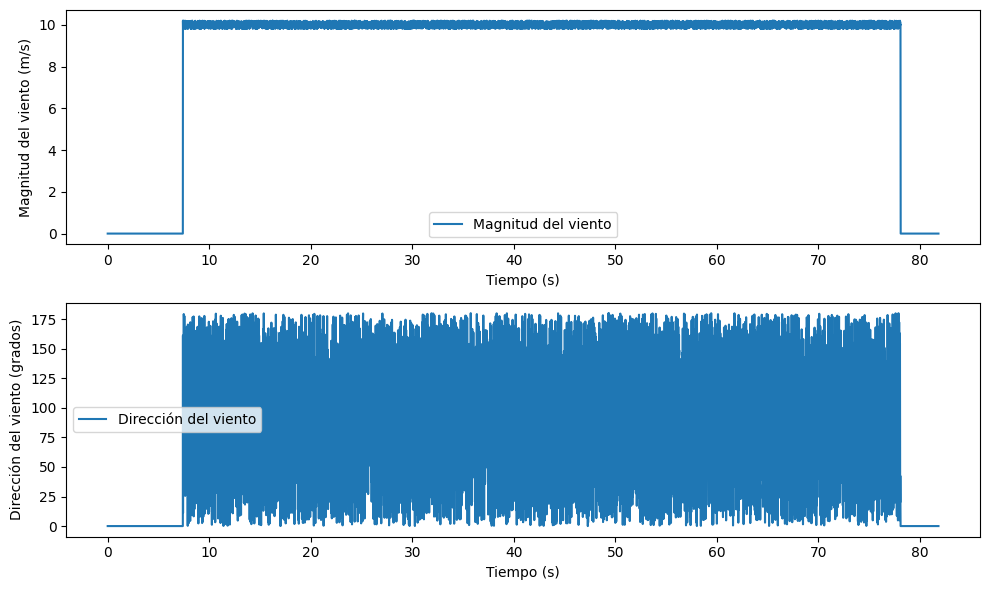

In [ ]:


# Plot the data
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.plot(tiempos[1:], vientomags, label="Magnitud del viento")
plt.xlabel("Tiempo (s)")
plt.ylabel("Magnitud del viento (m/s)")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(tiempos[1:], vientodirs, label="Dirección del viento")
plt.xlabel("Tiempo (s)")
plt.ylabel("Dirección del viento (grados)")
plt.legend()

plt.tight_layout()
plt.show()


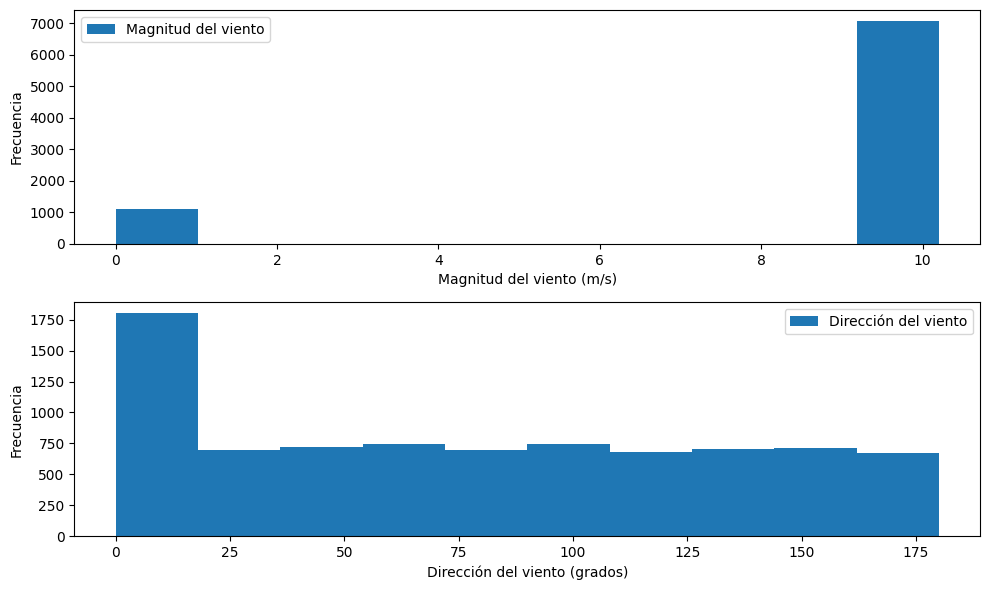

In [ ]:
# prompt: haz el histogramas de la magnitud y direccion del viento (vientomags y vientodirs)

import matplotlib.pyplot as plt
# Histogramas de magnitud y dirección del viento
plt.figure(figsize=(10, 6))

plt.subplot(2, 1, 1)
plt.hist(vientomags, bins=10, label="Magnitud del viento")
plt.xlabel("Magnitud del viento (m/s)")
plt.ylabel("Frecuencia")
plt.legend()

plt.subplot(2, 1, 2)
plt.hist(vientodirs, bins=10, label="Dirección del viento")
plt.xlabel("Dirección del viento (grados)")
plt.ylabel("Frecuencia")
plt.legend()

plt.tight_layout()
plt.show()


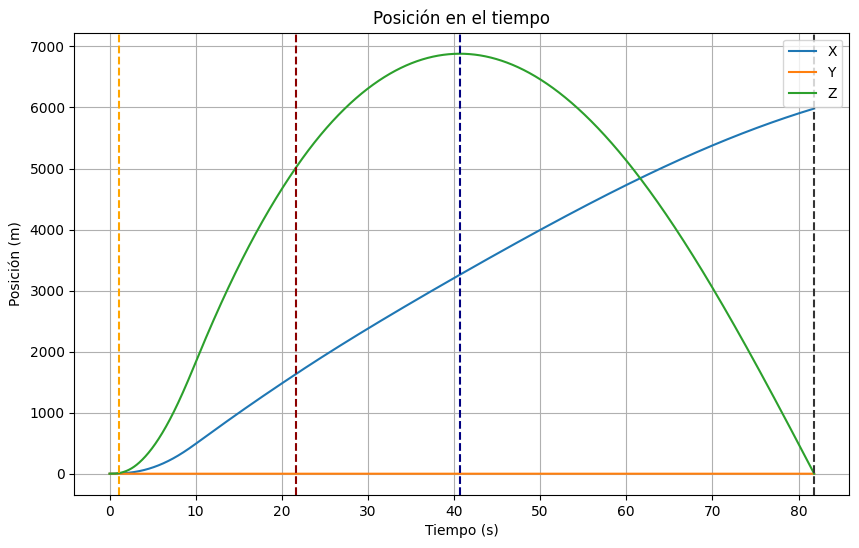

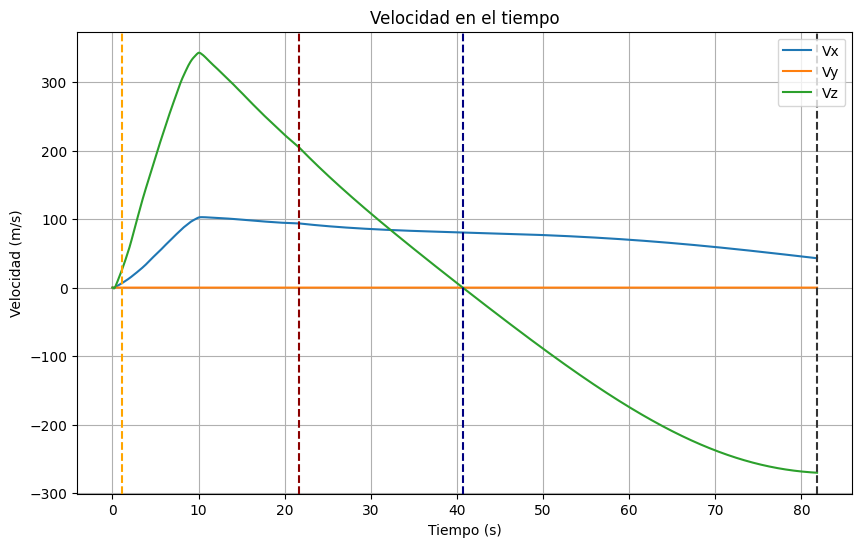

In [ ]:
# Posiciones
plt.figure(figsize=(10, 6))
plt.title("Posición en el tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (m)")
plt.plot(tiempos[1:], posiciones[:, 0], label="X")
plt.plot(tiempos[1:], posiciones[:, 1], label="Y")
plt.plot(tiempos[1:], posiciones[:, 2], label="Z")
vuelo1.muestra_tiempos()
plt.legend()
plt.grid(True)

# Velocidades
plt.figure(figsize=(10, 6))
plt.title("Velocidad en el tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (m/s)")
plt.plot(tiempos[1:], velocidades[:, 0], label="Vx")
plt.plot(tiempos[1:], velocidades[:, 1], label="Vy")
plt.plot(tiempos[1:], velocidades[:, 2], label="Vz")
# plt.plot(tiempos[1:], np.linalg.norm(velocidades[:, :]), label="Total", color="black")
vuelo1.muestra_tiempos()
plt.legend()
plt.grid(True)

# Mostrar las gráficas
plt.show()


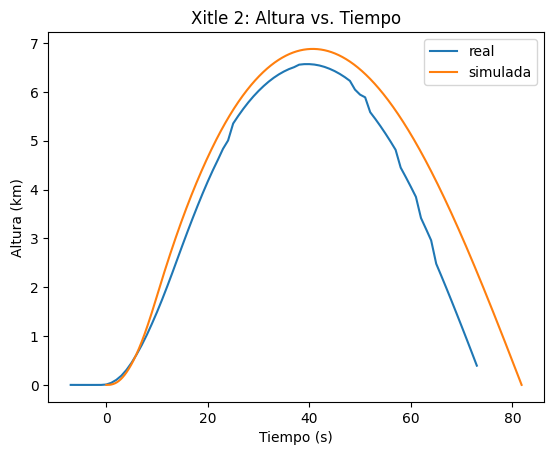

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
# Load the data from the CSV file
df = pd.read_csv('AlturavsTiempo-Xitle2.csv')

# Extract the altitude and time columns
altitude = df['ALTURA [km]']
time = df['tiempo [s]']

# Create a plot of altitude vs. time
plt.plot(time-7, altitude, label="real")
plt.plot(tiempos[1:], posiciones[:, 2]/1000, label="simulada")
plt.xlabel('Tiempo (s)')
plt.ylabel('Altura (km)')
plt.title('Xitle 2: Altura vs. Tiempo')
plt.legend()

# Show the plot
plt.show()


In [ ]:
# prompt: marcar el apogeo y los tiempos en la grafica anterior
# y colocar punto rojo en el valor maximo de cada plot con su valor impreso

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
# Load the data from the CSV file
df = pd.read_csv('AlturavsTiempo-Xitle2.csv')

# Extract the altitude and time columns
altitude = df['ALTURA [km]']
time = df['tiempo [s]']

# Create a plot of altitude vs. time
plt.plot(time-7, altitude, label="real")
plt.plot(tiempos[1:], posiciones[:, 2]/1000, label="simulada")
plt.xlabel('Tiempo (s)')
plt.ylabel('Altura (km)')
plt.title('Xitle 2: Altura vs. Tiempo')
plt.legend()

# Marcar el apogeo y los tiempos
plt.axvline(vuelo1.tiempo_apogeo, color="navy", ls="--", label="Apogeo")
plt.axvline(vuelo1.tiempo_salida_riel, color="orange", ls="--", label="Salida del riel")
plt.axvline(vuelo1.tiempo_impacto, color="0.2", ls="--", label="Impacto")

# Colocar punto rojo en el valor maximo de cada plot con su valor impreso
max_altitude = max(altitude)
max_altitude_index = altitude.index(max_altitude)
plt.plot(time[max_altitude_index]-7, max_altitude, 'ro')
plt.text(time[max_altitude_index]-7, max_altitude, f'{max_altitude:.2f} km', ha='center', va='bottom')

max_simulated_altitude = max(posiciones[:, 2]/1000)
max_simulated_altitude_index = np.argmax(posiciones[:, 2])
plt.plot(tiempos[max_simulated_altitude_index+1], max_simulated_altitude, 'ro')
plt.text(tiempos[max_simulated_altitude_index+1], max_simulated_altitude, f'{max_simulated_altitude:.2f} km', ha='center', va='bottom')

# Show the plot
plt.show()


Simulacion en accion (CON paracaidas)

In [ ]:
Mainchute = Parachute(1.2, 0.802) #Crear paracaidas principal
#print(Xitle.parachute_active1)
Xitle.agregar_paracaidas(Mainchute)
#print(Xitle.parachute_active1)
#print(Xitle.parachute_added)
#como le hago para agregar dos paracaidas??? el drogue y el main
vuelo_paracaidas = Vuelo(Xitle,atm_actual,viento_actual)
tiempos, sim, CPs, CGs, masavuelo = vuelo_paracaidas.simular_vuelo(estado,t_max, dt)

Tvecs, Dvecs, Nvecs, accels, palancas, accangs, Gammas, Alphas, torcas, Cds, Machs, vientomags, vientodirs = vuelo_paracaidas.calc_cantidades_secundarias(tiempos, sim)
posiciones = np.array([state[0:3] for state in sim])
velocidades = np.array([state[3:6] for state in sim])
thetas = np.array([state[6] for state in sim])
omegas = np.array([state[7] for state in sim])

#print(tiempo)
#print(posiciones)
print("Tiempo de salida del riel [s]",vuelo_paracaidas.tiempo_salida_riel)
print("Tiempo de MECO [s]",Xitle.t_MECO)
print("Tiempo de apogeo [s]",vuelo_paracaidas.tiempo_apogeo)
print("Tiempo de impacto [s]",vuelo_paracaidas.tiempo_impacto)

Tiempo de salida del riel [s] 1.0800000000000007
Tiempo de MECO [s] 21.62
Tiempo de apogeo [s] 40.680000000000476
Tiempo de impacto [s] 288.45999999988265


# **GRÁFICAS**


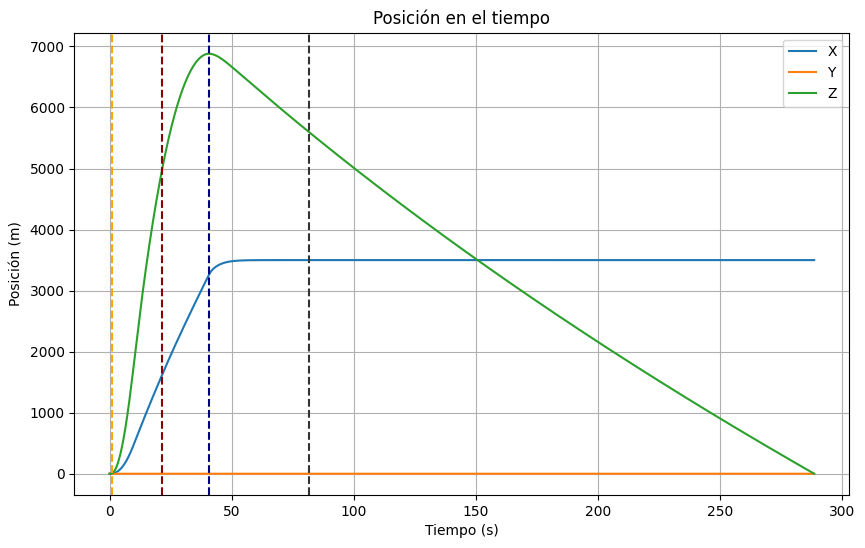

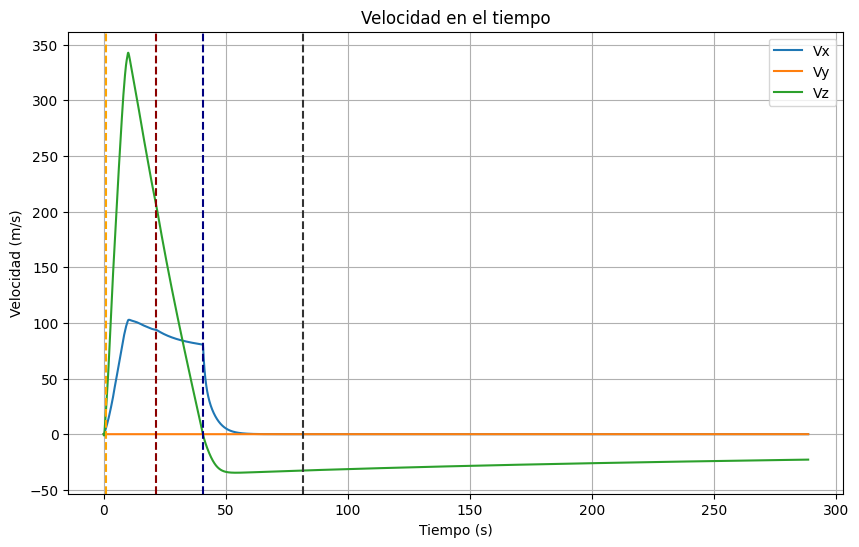

In [ ]:
# Posiciones
plt.figure(figsize=(10, 6))
plt.title("Posición en el tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición (m)")
plt.plot(tiempos[1:], posiciones[:, 0], label="X")
plt.plot(tiempos[1:], posiciones[:, 1], label="Y")
plt.plot(tiempos[1:], posiciones[:, 2], label="Z")
vuelo1.muestra_tiempos()
plt.legend()
plt.grid(True)

# Velocidades
plt.figure(figsize=(10, 6))
plt.title("Velocidad en el tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Velocidad (m/s)")
plt.plot(tiempos[1:], velocidades[:, 0], label="Vx")
plt.plot(tiempos[1:], velocidades[:, 1], label="Vy")
plt.plot(tiempos[1:], velocidades[:, 2], label="Vz")
# plt.plot(tiempos[1:], np.linalg.norm(velocidades[:, :]), label="Total", color="black")
vuelo1.muestra_tiempos()
plt.legend()
plt.grid(True)


# Mostrar las gráficas
plt.show()


In [ ]:

max_altitude = max(posiciones[:, 2])
max_speed = max(np.linalg.norm(velocidades, axis=1))

print("APOGEO:", max_altitude, "metros")
print("Máxima velocidad:", max_speed, "m/s")
print("Equivalente a:",max_speed/340, "Mach")

In [ ]:
# Graficar angulos contra el tiempo
plt.figure(figsize=(10, 6))
plt.title("Comportamiento angular en el tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (grados)")
plt.plot(tiempos[1:], nice_angle(thetas), label="Theta")
plt.plot(tiempos[1:], nice_angle(omegas), label="Omega",alpha=0.5)
vuelo1.muestra_tiempos()
plt.axhline(riel.angulo, ls="--", color="lightgray")
plt.axhline(-90, ls="--", color="lightgray")
plt.legend()
plt.grid(True)
# plt.xlim(150,300); plt.ylim(-20, 20)
plt.show()


## Graficas del estado de vuelo

In [ ]:
Tmags = np.array([np.linalg.norm(Tvec) for Tvec in Tvecs])
Dmags = np.array([np.linalg.norm(Dvec) for Dvec in Dvecs])
Nmags = np.array([np.linalg.norm(Nvec) for Nvec in Nvecs])


plt.title("Fuerzas en el tiempo")
plt.plot(tiempos[1:], Tmags, label= "Empuje")
plt.plot(tiempos[1:], Nmags,label="Normal")
plt.plot(tiempos[1:], Dmags, label= "Arrastre")
vuelo1.muestra_tiempos()


plt.xlim(0,vuelo1.tiempo_apogeo+10)
plt.legend()

In [ ]:
# Graficar componentes de las fuerzas

Txs, Tys, Tzs = zip(*Tvecs)
Dxs, Dys, Dzs = zip(*Dvecs)
Nxs, Nys, Nzs = zip(*Nvecs)

plt.figure(figsize=(18,4))

plt.subplot(1, 3, 1)
plt.title("Empuje [N]")
plt.ylabel("Newtons")
plt.plot(tiempos[1:], Txs, label="X")
plt.plot(tiempos[1:], Tys, label="Y")
plt.plot(tiempos[1:], Tzs, label="Z")
plt.axvline(vuelo1.tiempo_salida_riel, color="orange", ls="--")
plt.axvline(Xitle.t_MECO, color="darkred", ls="--")
plt.axvline(vuelo1.tiempo_apogeo, color="navy", ls="--")
plt.xlim(0,Xitle.t_MECO+1)
plt.legend()

plt.subplot(1, 3, 2)
plt.title("Arrastre [N]")
#plt.ylabel("Newtons")
plt.plot(tiempos[1:], Dxs, label="X")
plt.plot(tiempos[1:], Dys, label="Y")
plt.plot(tiempos[1:], Dzs, label="Z")
vuelo1.muestra_tiempos()
plt.xlim(0,vuelo1.tiempo_apogeo+1)
plt.legend()

plt.subplot(1, 3, 3)
plt.title("Normal [N]")
#plt.ylabel("Newtons")
plt.plot(tiempos[1:], Nxs, label="X")
plt.plot(tiempos[1:], Nys, label="Y")
plt.plot(tiempos[1:], Nzs, label="Z")
vuelo1.muestra_tiempos()
#plt.xlim(0,vuelo1.tiempo_apogeo+1)
#plt.ylim(-6,2.2)
plt.legend()

plt.show()

In [ ]:
CGs = np.array(CGs)
CPs = np.array(CPs)

#si se definen asi los calibres???
stab = (CPs-CGs)/diam_ext
plt.plot(tiempos[1:], CGs[:,2],label="CG")
plt.plot(tiempos[1:], CPs[:,2],label="CP")
plt.title("Posición axial del CG y del CP")
plt.xlabel("Tiempo (s)")
plt.ylabel("Posición axial (m)")
vuelo1.muestra_tiempos()
plt.legend()

ax2 = plt.twinx()
plt.plot(tiempos[1:], stab[:,2], color="C2",label="estabilidad")
plt.ylabel("Estabilidad (calibres)")
#plt.xlim(0,vuelo1.tiempo_apogeo+10)
plt.legend()

In [ ]:
# Componentes del brazo de palanca
palancas = np.array(palancas)
plt.plot(tiempos[1:], palancas[:,0], label="x")
plt.plot(tiempos[1:], palancas[:,1], label="y")
plt.plot(tiempos[1:], palancas[:,2], label="z")
# plt.plot(tiempo[1:], list(np.linalg.norm(p) for p in palancas))
#plt.xlim(0,vuelo1.tiempo_apogeo+10)
plt.legend()
plt.title("Componentes del brazo de palanca")
plt.xlabel("Tiempo (s)")

vuelo1.muestra_tiempos()
plt.show()

In [ ]:
# Graficar velocidad y aceleración angular (derivada de theta)

plt.figure(figsize=(16,5))

plt.subplot(1, 4, 1)
plt.plot(tiempos[1:], nice_angle(thetas))
#plt.xlim(0,vuelo1.tiempo_apogeo+10)
vuelo1.muestra_tiempos()
plt.title("Ángulo de inclinación (Pitch)")#pitch (theta)

plt.subplot(1, 4, 2)
plt.plot(tiempos[1:], nice_angle(omegas))
plt.axhline(0, ls="--", color="lightgray")
#plt.xlim(0,vuelo1.tiempo_apogeo+10)
vuelo1.muestra_tiempos()
plt.title("Velocidad angular(omega)")

plt.subplot(1, 4, 3)
plt.plot(tiempos[1:], nice_angle(accangs))
#plt.xlim(0,vuelo1.tiempo_apogeo+10)
vuelo1.muestra_tiempos()
plt.title("Aceleración angular")

plt.subplot(1, 4, 4)
palancas = np.array(palancas)
plt.plot(tiempos[1:], palancas[:,0],label= "comp x")
plt.plot(tiempos[1:], palancas[:,1],label="comp y")
plt.plot(tiempos[1:], palancas[:,2], label = "comp z")
plt.title("Componentes del brazo de momento")
#plt.xlim(0,vuelo1.tiempo_apogeo+10)
vuelo1.muestra_tiempos()
plt.legend()

plt.show()

In [ ]:
#torcas = np.array(torcas)
#print(torcas)
#print(torcas[:,0,1])

#plt.plot(tiempo[1:], torcas[:,0,1], label="Torca", color="C4")
#plt.axhline(0, ls="--", color="0.7")
# plt.ylim(-10, 10)
#plt.twinx()
# plt.plot(tiempo[1:], Thetas[:], label="Theta", color="C1")
#plt.plot(tiempo[1:], Alphas[:], label="Alpha", color="C2")
#plt.legend()
# plt.ylim(-5, 5)
#plt.axhline(88, ls="--", color="0.7")
#plt.xlim(0, 10)


In [ ]:
plt.figure(figsize=(14,4))
plt.title("Ángulos en el tiempo")
plt.xlabel("Tiempo (s)")
plt.ylabel("Ángulo (grados º)")
plt.plot(tiempos[1:], [normalize_angle(x) for x in np.rad2deg(thetas)], label = 'Ángulo de inclinación (theta)')#pitch
plt.plot(tiempos[1:], [normalize_angle(x) for x in np.rad2deg(Gammas)], label = 'Ángulo de vuelo (gamma)')#FPA
plt.plot(tiempos[1:], [normalize_angle(x) for x in np.rad2deg(Alphas)],label = 'Ángulo de ataque (alpha)')
plt.axvline(vuelo1.tiempo_apogeo, color="0.5")
plt.axhline(0, ls="--", color="gray")
plt.axhline(riel.angulo, ls="--", color="lightgray")
plt.axhline(-90, ls="--", color="lightgray")
# plt.xlim(0,vuelo1.tiempo_apogeo+20)
vuelo1.muestra_tiempos()
plt.legend()
plt.xlim(0,100)
#plt.ylim(75,80.5)

In [ ]:
plt.xlabel('Tiempo (s)')
plt.ylabel('Masa (kg)')
plt.title('Masa del cohete Xitle en el tiempo')
plt.xlim(0,vuelo1.tiempo_apogeo+5)
vuelo1.muestra_tiempos()
plt.plot(tiempos, masavuelo)

In [ ]:
# Graficar trayectoria
plt.xlabel('Alcance (m)')
plt.ylabel('Altura (m)')
plt.title('Trayectoria del cohete Xitle en el tiempo')
plt.plot(posiciones[:, 0], posiciones[:, 2])
# plt.ylim(0, 10000)
plt.gca().set_aspect("equal")


In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np

# Extract the positions of the trajectory
posiciones = np.array([state[0:3] for state in sim])

# Extract the launch and impact points
launch_point = posiciones[0]
impact_point = posiciones[-1]

# Create the figure and 3D axes
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory
ax.plot(posiciones[:, 0], posiciones[:, 1], posiciones[:, 2])

# Plot the launch and impact points with different colors
ax.scatter(launch_point[0], launch_point[1], launch_point[2], c='blue', label='Punto de lanzamiento')
ax.scatter(impact_point[0], impact_point[1], impact_point[2], c='red', label='Punto de impacto')

# Create a circle in the xy plane with a diameter of 1000 meters around the impact point
circle_radius = 1000
circle_points = np.linspace(0, 2*np.pi, 100)
circle_x = impact_point[0] + circle_radius * np.cos(circle_points)
circle_y = impact_point[1] + circle_radius * np.sin(circle_points)

# Plot the circle in the xy plane
ax.plot(circle_x, circle_y, 0, color='gray', linestyle='--', label='1000 m radio de seguridad')

# Set labels, title, and limits
ax.set_xlabel("Alcance (m)")
ax.set_ylabel("Desplazamiento (m)")
ax.set_zlabel("Altura (m)")
ax.set_title("Trayectoria del cohete Xitle en el tiempo")
#ax.set_xlim(0, 10000)
#ax.set_ylim(0, 10000)
#ax.set_zlim(0, 10000)

# Add legend and show plot
ax.legend()
plt.show()


In [ ]:
posiciones = np.array([state[0:3] for state in sim])

# Extract the launch and impact points
launch_point = posiciones[0]
impact_point = posiciones[-1]

# Create the figure and 3D axes
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection="3d")

# Plot the trajectory
ax.plot(posiciones[:, 0], posiciones[:, 1], posiciones[:, 2])

# Plot the launch and impact points with different colors
ax.scatter(launch_point[0], launch_point[1], launch_point[2], c='blue', label='Punto de lanzamiento')
ax.scatter(impact_point[0], impact_point[1], impact_point[2], c='red', label='Punto de impacto')

# Create a circle in the xy plane with a diameter of 1000 meters around the impact point
circle_radius = 1000
circle_points = np.linspace(0, 2*np.pi, 100)
circle_x = impact_point[0] + circle_radius * np.cos(circle_points)
circle_y = impact_point[1] + circle_radius * np.sin(circle_points)

# Plot the circle in the xy plane
ax.plot(circle_x, circle_y, 0, color='gray', linestyle='--', label='1000 m radio de seguridad')

# Set labels, title, and limits
ax.set_xlabel("Alcance (m)")
ax.set_ylabel("Desplazamiento (m)")
ax.set_zlabel("Altura (m)")
ax.set_title("Trayectoria y orientaciones del cohete Xitle en el tiempo")

# Add legend and show plot
ax.legend()

# Add an arrow indicating the launch angle
# Create a rotation matrix
theta_rad = np.deg2rad(riel.angulo)
#rotation_matrixY = np.array([[np.cos(theta_rad),0, np.sin(theta_rad)],
#                               [0,1,0],
#                            [-np.sin(theta_rad), 0, np.cos(theta_rad)]])

rotation_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad), 0],
                            [np.sin(theta_rad), np.cos(theta_rad), 0],
                            [0, 0, 1]])


launch_vector = rotation_matrix @ np.array([800, 0, 0])
ax.quiver(launch_point[0], launch_point[1], launch_point[2], launch_vector[0], launch_vector[1], launch_vector[2], color='green', arrow_length_ratio=0.1)

# Add projections of the trajectory onto the xy, xz, and yz planes
ax.plot(posiciones[:, 0], posiciones[:, 1], 0, color='black', linestyle='--', alpha=0.5)
ax.plot(posiciones[:, 0], posiciones[:, 2], 0, color='black', linestyle='--', alpha=0.7)
ax.plot(posiciones[:, 1], posiciones[:, 2], 0, color='black', linestyle='--', alpha=0.5)

# Set limits for each plane
#ax.set_xlim(0, 10000)
#ax.set_ylim(0, 10000)
#ax.set_zlim(0, 10000)

# Show the plot
plt.show()


In [ ]:
# prompt: instala pip install mpl_toolkits.basemap

#!pip install mpl_toolkits.basemap
#!pip install basemap
#!pip install basemap-data-hires

In [ ]:
plt.plot(tiempos[1:], velocidades[:, 2])
# plt.plot(tiempos, velocidades[:, 2])
plt.axhline(0, ls="--", color="gray")
plt.ylim(-500, 600)
plt.xlabel('Tiempo (s)')
plt.ylabel('Velocidad (m\s)')
plt.axvline(vuelo1.tiempo_salida_riel, color="orange", ls="--")
plt.axvline(Xitle.t_MECO, color="darkred", ls="--")
plt.axvline(vuelo1.tiempo_apogeo, color="navy", ls="--")
plt.title('Velocidad vertical del cohete Xitle en el tiempo')
plt.xlim(0,vuelo1.tiempo_apogeo+10)

ax2 = plt.twinx()
plt.axhline(0, ls="--", color="gray")
plt.ylabel('Ángulos (º)')
plt.plot(tiempos[1:], Alphas, color="C2", label="ataque")
plt.plot(tiempos[1:], Gammas, color="C4", label= "FPA")
plt.xlim(0,vuelo1.tiempo_apogeo+10)
plt.legend()


plt.show()

In [ ]:
# prompt: grafica la torca

import matplotlib.pyplot as plt
plt.plot(tiempos[1:], torcas, label="Torca", color="C4")
plt.axhline(0, ls="--", color="0.7")
plt.ylim(-10, 10)
plt.twinx()
plt.plot(tiempos[1:],np.rad2deg(thetas), label = 'Pitch (theta)',color="C1")
#plt.plot(tiempos[1:], Alphas, label="Alpha", color="C2")
#plt.legend()
#plt.ylim(-5, 5)
plt.axhline(88, ls="--", color="0.7")
#plt.xlim(0, 10)

vuelo1.muestra_tiempos()
plt.title("Torcas y theta")


In [ ]:
# Checar rotación del brazo de palanca
theta = np.deg2rad(45)
s = np.sin(theta)
c = np.cos(theta)
M_rot = np.array([[s,0,-c],[0, 1, 0],[c, 0 , -s]])
print(M_rot)
r = np.array((0,0,1))
print(r)
rprim = M_rot @ r
print(rprim)

In [ ]:
ln1, = plt.plot(tiempos[1:], Cds, label="Coeficiente de arrastre", color="C5")
plt.ylabel("Cd")
plt.twinx()
ln2, = plt.plot(tiempos[1:], Machs, label="Número de Mach", color= "C8")
plt.axhline(1.0, ls="--", color="r")
plt.axvline(vuelo1.tiempo_salida_riel, color="orange")
plt.axvline(Xitle.t_MECO, color="darkred")
plt.axvline(vuelo1.tiempo_apogeo, color="0.5")
plt.xlabel("Tiempo (s)")
plt.ylabel("Mach")
plt.title("Coeficiente de arrastre y numero de Mach")

vuelo1.muestra_tiempos()
plt.legend(handles=[ln1, ln2])
plt.show()


In [ ]:
# prompt: grafica la altura contra tiempo que estan en el csv AlturavsTiempo-Xitle2

import matplotlib.pyplot as plt
import pandas as pd

# Load the data from the CSV file
df = pd.read_csv('AlturavsTiempo-Xitle2.csv')

# Extract the altitude and time columns
altitude = df['ALTURA [km]']
time = df['tiempo [s]']

# Create a plot of altitude vs. time
plt.plot(time, altitude)

# Set the labels and title
plt.xlabel('Time (s)')
plt.ylabel('Altitude (km)')
plt.title('Altitude vs. Time for Xitle 2')

# Show the plot
plt.show()

# Grafica del cohete sobre una linea

In [ ]:
print(CG_list)
print(CP_list)
print(long_list)
p=len(CG_list)-1

import matplotlib.pyplot as plt

y = np.zeros_like(CG_list)
y_long = np.zeros_like(long_list)

plt.figure(figsize=(12,1.5))
plt.plot(long_list,y_long,color= 'lightblue',alpha=0.9)
plt.scatter(long_list,y_long,color='navy',marker="|")
plt.scatter(CG_list[:p],y[:p],color='darkorange')#CGs de los componentes
plt.scatter(CP_list[:p],y[:p],color='green') #CPs de los componentes
plt.scatter(CG_list[-1],y[-1],color='red',marker="*", s=100) #CG del cohete complfuncompleto
plt.scatter(CP_list[-1],y[-1],color='blue',marker= "*", s=100) #CP del cohete complfuncompleto

plt.title("CG y CP posicionados de los componentes en Cohete Xitle2")
plt.show()

In [ ]:
# Define the length of the line
line_length = 0.5

# Create a figure and axes
fig, ax = plt.subplots()

# Loop through each angle and plot the rotated line
for theta in thetas:

    k=0

    # Convert the angle to radians
    theta_rad = theta
    theta_deg = np.rad2deg(theta)

    # Create a rotation matrix
    rotation_matrix = np.array([[np.cos(theta_rad), -np.sin(theta_rad)],
                               [np.sin(theta_rad), np.cos(theta_rad)]])

    # Define the line endpoints
    start_point = np.array([0, 0])
    end_point = start_point + rotation_matrix @ np.array([line_length, 0])

    k= k+1

    # Plot the line
    ax.plot([start_point[0], end_point[0]], [start_point[1], end_point[1]])

# Show the plot
plt.show()


In [ ]:
#  grafica sobre el mapa el punto dado por las coordenadas de lanzamiento y grafica la trayectoria del vuelo

import numpy as np
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt

factor = 0.0005
# Define the launch coordinates
launch_latitude = 32
launch_longitude = -106

# Create a Basemap instance
m = Basemap(projection='cyl', llcrnrlat=launch_latitude-factor, urcrnrlat=launch_latitude+factor,
            llcrnrlon=launch_longitude+factor, urcrnrlon=launch_longitude-factor, resolution='h')

# Draw the coastlines and fill the continents
m.drawcoastlines(color='#135')
m.fillcontinents(color='#eee', lake_color='#aaa')

# Draw the launch point
x_im, y_im = m(posiciones[-1,0], posiciones[-1,1])
m.scatter(x_im, y_im, latlon=True, s=50, c='black', marker='o')

# Draw the impact point

xpt, ypt = m(launch_longitude, launch_latitude)
m.scatter(xpt, ypt, latlon=True, s=50, c='r', marker='o')

# Convert the positions to latitude and longitude
latitudes = posiciones[:, 1]
longitudes = posiciones[:, 0]

# Transform the coordinates to the map projection
x, y = m(longitudes, latitudes)

# Plot the trajectory
m.plot(x, y, latlon=True, color='b', linewidth=2)

# Add labels and title
m.drawparallels(np.arange(32, 32.05, 0.5), labels=[True, True, True, True], size=10)
m.drawmeridians(np.arange(-106, -106.05, 0.5), labels=[True, True, True, True], size=10)
plt.title("Trayectoria del cohete Xitle")

# Show the plot
plt.show()